# vision.transform

---

## 图像变换

fastai在PyTorch中提供了从头开始编写的完整图像转换库。 虽然该库的主要用途是在训练计算机视觉模型时使用的数据增强，但您也可以将其用于更一般的图像转换目的。 在我们深入了解完整API的细节之前，我们将快速概述一下您几乎肯定需要使用的数据增强部分。

---

## 数据增加

在训练计算机视觉模型时，数据增强可能是最重要的正则化技术：我们不是每次都使用相同的图片为模型提供数据，而是进行小的随机变换（一些旋转，缩放，平移等......） 不要改变图像内部（人眼）的内容，但要更改其像素值。 通过数据增强训练的模型将更好地概括。

要获得一组具有默认值的变换，这些变换在各种任务中都能很好地工作，使用`get_transforms`通常最容易。 根据数据中图像的性质，您可能需要调整一些参数，最重要的是：

* `do_flip`：如果为True则随机翻转图像（默认行为）
* `flip_vert`：将翻转限制为水平翻转（当为假时）或水平和垂直翻转以及90度旋转（当为True时）

`get_transforms`返回两个变换列表的元组：一个用于训练集，一个用于验证集（我们不想修改验证集中的图片，因此第二个变换列表仅限于调整图片大小）。 这可以直接传递以定义DataBunch对象（参见下文），然后该对象与模型相关联以开始训练。

请注意，get_transforms的默认值通常对于常规照片非常有用 - 尽管我们会在这里添加一些额外的旋转，因此更容易看到差异。

In [1]:
from fastai.vision import *
from fastai.basics import *
from fastai.callbacks import *

In [10]:
tfms = get_transforms(max_rotate=25)
len(tfms)

2

我们首先定义一个函数来返回一个新图像，因为转换函数会修改它们的输入。 我们还定义了一个小辅助函数plots_f，让我们根据函数输出变换图像的网格 - 这个函数的细节在这里并不重要。

In [11]:
def get_ex(): return open_image('imgs/cat_example.jpg')

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

如果我们想看看这些转换实际上做了什么，我们需要使用apply_tfms函数。 它将负责选择随机参数的值并对Image对象进行转换。 此函数有多个可以自定义的参数（有关详细信息，请参阅其文档）; 在这里我们将突出最有用的。 我们需要设置的第一个，特别是如果我们的图像具有不同的形状，是目标尺寸。 它将确保所有图像都被裁剪或填充到相同的大小，以便我们可以将它们整理成批次。

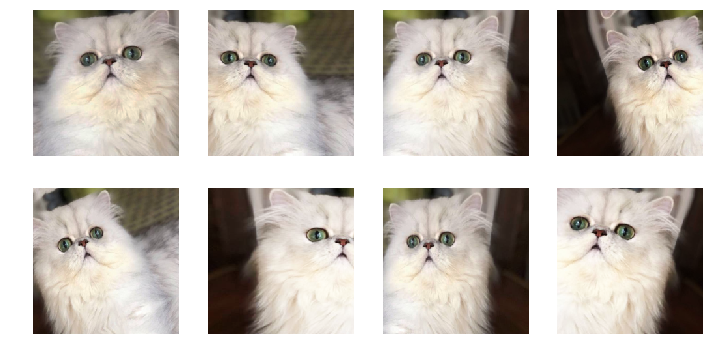

In [13]:
plots_f(2, 4, 12, 6, size=224)

请注意，如果指定int元组，则目标大小可以是矩形。

`注意：在fastai中，我们遵循numpy和pytorch的惯例来处理图像尺寸:(高度，宽度）。 它与PIL或matplolib不同，所以不要混淆。`

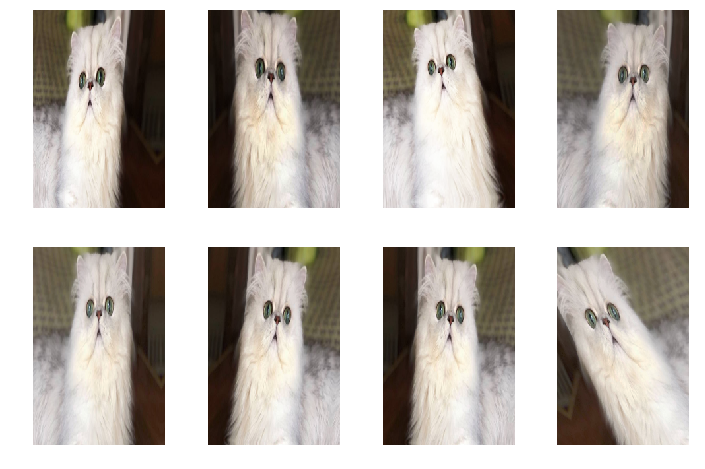

In [14]:
plots_f(2, 4, 12, 8, size=(300,200))

可以自定义的第二个参数是我们如何处理缺失的像素：当应用变换（如旋转）时，正方形内的一些像素将不具有图像中的值。 我们可以将缺少的像素设置为以下之一：
* 黑色（padding_mode ='zeros'）
* 最近边框处像素的值（padding_mode ='border'）
* 与最近边界对称的像素值（padding_mode ='reflection'）

padding_mode ='reflection'是默认值。 这是padding_mode ='zeros'的样子：

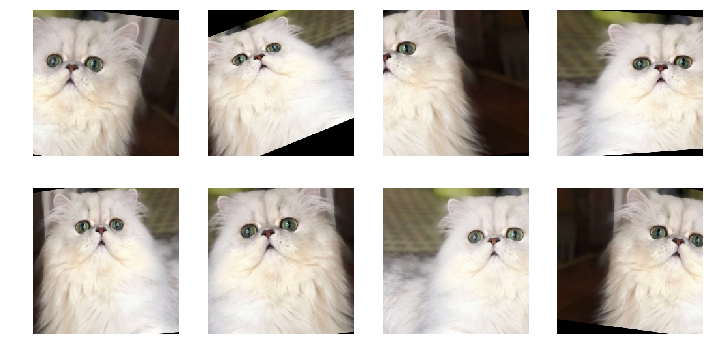

In [15]:
plots_f(2, 4, 12, 6, size=224, padding_mode='zeros')

padding_mode ='border'如下所示：

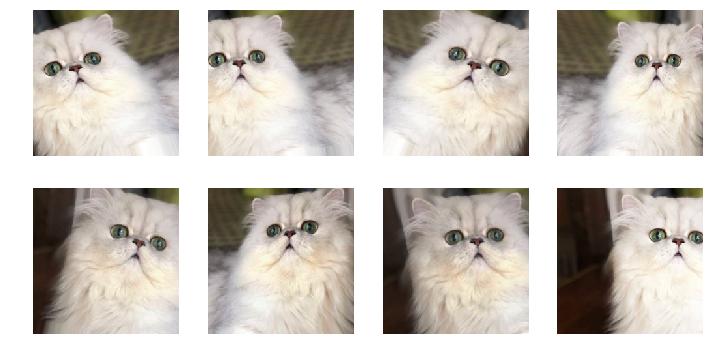

In [16]:
plots_f(2, 4, 12, 6, size=224, padding_mode='border')

可能对更改有用的第三个参数是resize_method。 图像通常是不同比例的矩形，因此为了使它们达到目标尺寸，我们可能需要裁剪，挤压或填充它们以使比率正确。

默认情况下，库会调整图像大小，同时保持其原始比例，以便较小的大小对应于给定的大小，然后进行裁剪（ResizeMethod.CROP）。 您可以选择在保持原始比例的同时调整图像大小，以便更大的尺寸对应于给定的大小，然后使用垫（ResizeMethod.PAD）。 另一种方法是将图像压缩到给定的大小（ResizeMethod.SQUISH）。


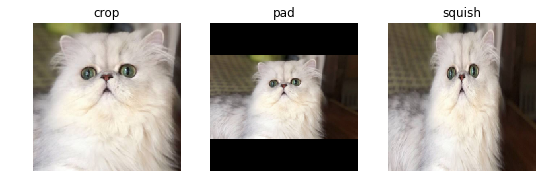

In [17]:
_,axs = plt.subplots(1,3,figsize=(9,3))
for rsz,ax in zip([ResizeMethod.CROP, ResizeMethod.PAD, ResizeMethod.SQUISH], axs):
    get_ex().apply_tfms([crop_pad()], size=224, resize_method=rsz, padding_mode='zeros').show(ax=ax, title=rsz.name.lower())

---

## 数据增加细节
如果要快速获得一组在各种任务中运行良好的随机变换，则应使用get_transforms函数。 要调整的最重要参数是do_flip和flip_vert，具体取决于您拥有的图像类型。

**get_transforms**

`get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75, xtra_tfms:Optional[Collection[Transform]]=None) → Collection[Transform]`

Utility func可轻松创建翻转，旋转，缩放，扭曲，灯光变换列表:

* `do_flip`：如果为True，则以0.5的概率应用随机翻转
* `flip_vert`：需要do_flip = True。 如果为True，则可以垂直翻转图像或旋转90度，否则仅应用水平翻转
* `max_rotate`：如果不是None，则应用概率为p_affine的-max_rotate和max_rotate度之间的随机旋转
* `max_zoom`：如果不是1.或更小，则随机缩放在1.和max_zoom之间应用概率p_affine
* `max_lighting`：如果不是None，则由max_lighting控制的随机闪电和对比度变化以概率p_lighting应用
* `max_warp`：如果不是None，则使用概率p_affine应用-max_warp和maw_warp之间的随机对称扭曲
* `p_affine`：应用每个仿射变换和对称扭曲的概率
* `p_lighting`：应用每个光照变换的概率
* `xtra_tfms`：您希望应用的其他变换列表

此函数返回两个变换列表的元组，一个用于训练集，另一个用于验证集（默认情况下仅限于中心裁剪）。

In [18]:
tfms = get_transforms(max_rotate=25); len(tfms)

2

让我们看看get_transforms现在如何改变这只小猫。

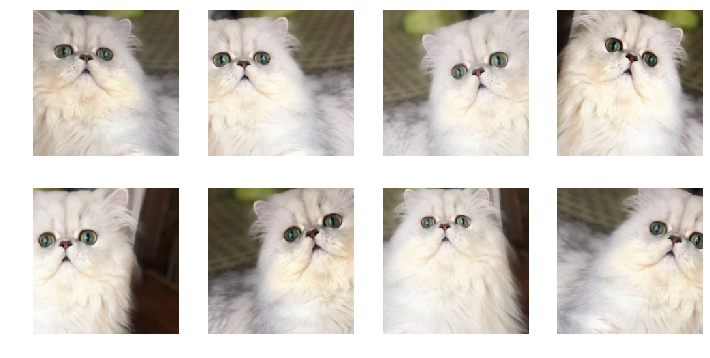

In [19]:
plots_f(2, 4, 12, 6, size=224)

另一个提供基本变换的有用函数是zoom_crop：

**zoom_crop**

`zoom_crop(scale:float, do_rand:bool=False, p:float=1.0)`

随机缩放和/或裁剪:

* `scale`：缩放或小数范围以缩放图像
* `do_rand`：如果为true，则变换是随机的，否则它是缩放比例和中心裁剪
* `p`：应用缩放的概率

如果do_rand为False，则scale应该是给定的float，否则它可以是一系列浮点数（并且zoom之间将有一个随机值）。 再次，这是对这可以给我们的感觉：

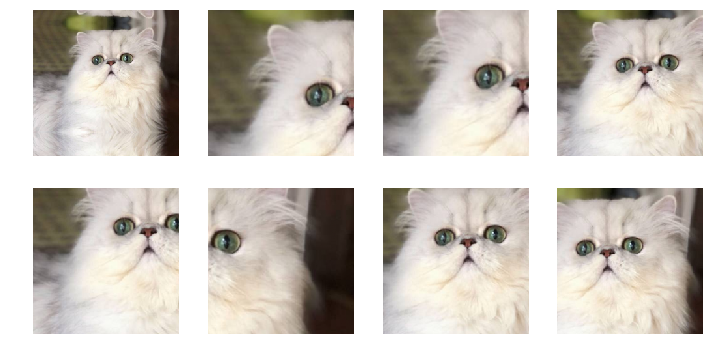

In [20]:
tfms = zoom_crop(scale=(0.75,2), do_rand=True)
plots_f(2, 4, 12, 6, size=224)

**rand_resize_crop**

`rand_resize_crop(size:int, max_scale:float=2.0, ratios:Point=(0.75, 1.33))`

在缩放max_scale之后，随机调整大小并将图像裁剪为比率。

* size：图像的最终尺寸
* max_scale：将图像缩放到随机比例
* ratios：随机选择新比率的比率范围

基于Andrew Howard对基于深度卷积神经网络的图像分类的一些改进，该变换是自2013年以来用于几乎所有获胜的Imagenet条目的主要方法的实现。 它在随机比例和挤压到新比率之后确定图像的新宽度和高度。 那些以0.5的概率切换。 然后，如果宽度和高度都小于图像的相应大小，则返回计算宽度和高度的图像部分，以row_pct为中心，col_pct。 否则我们再次使用新的随机参数。

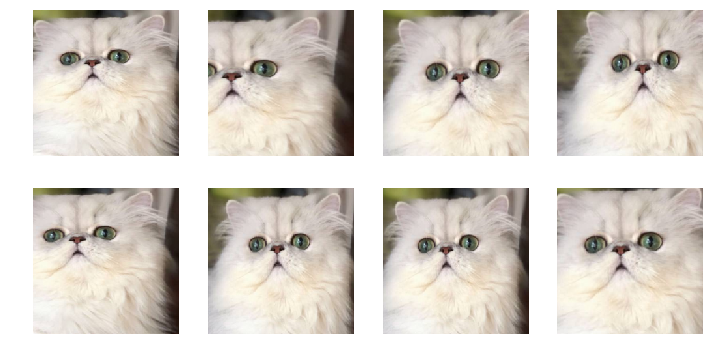

In [21]:
tfms = [rand_resize_crop(224)]
plots_f(2, 4, 12, 6, size=224)

---

## 随机性

定义每个变换的函数，例如rotateor flip_lr是确定性的。 然后，fastai 库将以两种不同的方式随机化它们：
* 每个变换都可以使用名为p的参数来定义，该参数表示应用它的概率
* 使用随机函数（如uniform或rand_bool）进行类型注释的每个参数都可以被此函数接受的参数元组替换，并且在每次调用调用时，函数内部传递的参数将被随机选取 使用该随机函数。

如果我们查看函数rotate，例如，我们看到它有一个参数degrees，它被注释为uniform。

第一级随机性：我们可以使用旋转来定义一个变量，其中度数固定为一个值，但是通过传递参数p。 然后以p的概率执行旋转，但始终具有相同的度数值。

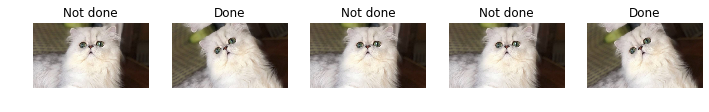

In [23]:
tfm = [rotate(degrees=30, p=0.5)]
fig, axs = plt.subplots(1,5,figsize=(12,4))
for ax in axs:
    img = get_ex().apply_tfms(tfm)
    title = 'Done' if tfm[0].do_run else 'Not done'
    img.show(ax=ax, title=title)

第二级随机性：我们可以使用旋转来定义变换，其中度数被定义为范围，没有参数p。 然后始终执行旋转，并在我们放入度数的两个浮点之间均匀地拾取随机值。

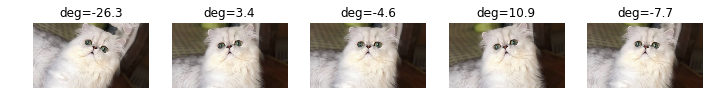

In [24]:
tfm = [rotate(degrees=(-30,30))]
fig, axs = plt.subplots(1,5,figsize=(12,4))
for ax in axs:
    img = get_ex().apply_tfms(tfm)
    title = f"deg={tfm[0].resolved['degrees']:.1f}"
    img.show(ax=ax, title=title)

全部组合：我们可以使用旋转定义变换，其中度数定义为范围，参数p。 然后以概率p执行旋转，并且在我们放入度数的两个浮点之间均匀地拾取随机值。

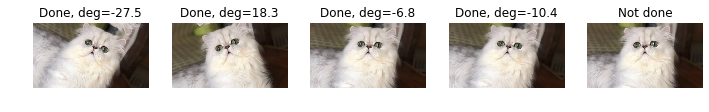

In [25]:
tfm = [rotate(degrees=(-30,30), p=0.75)]
fig, axs = plt.subplots(1,5,figsize=(12,4))
for ax in axs:
    img = get_ex().apply_tfms(tfm)
    title = f"Done, deg={tfm[0].resolved['degrees']:.1f}" if tfm[0].do_run else f'Not done'
    img.show(ax=ax, title=title)

---

## 变换列表

以下是构建转换的所有确定性函数的列表。 如前所述，它们中的每一个都可以具有被执行的概率p，并且任何时候用随机函数对参数进行类型注释，可以通过该函数使其随机化。

**brightness**

`brightness(x, change:uniform) → Image :: TfmLighting`

应用图像x亮度的变化。

此变换根据变化值调整图像的亮度。 更改为0会将图像转换为黑色，更改为1会将图像转换为白色。 change = 0.5不调整亮度。


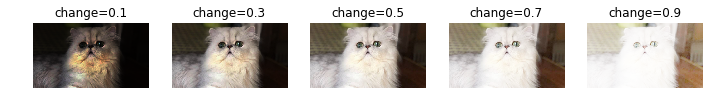

In [27]:
fig, axs = plt.subplots(1,5,figsize=(12,4))
for change, ax in zip(np.linspace(0.1,0.9,5), axs):
    brightness(get_ex(), change).show(ax=ax, title=f'change={change:.1f}')

**contrast**

`contrast(x, scale:log_uniform) → Image :: TfmLighting`

将比例应用于图像x的对比度。

比例调整对比度。 比例为0会将图像转换为灰色，而超过1的比例会将图像转换为超对比度。 scale = 1.不调整对比度。

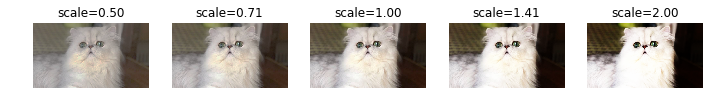

In [28]:
fig, axs = plt.subplots(1,5,figsize=(12,4))
for scale, ax in zip(np.exp(np.linspace(log(0.5),log(2),5)), axs):
    contrast(get_ex(), scale).show(ax=ax, title=f'scale={scale:.2f}')

In [33]:
doc(crop)

**crop**

`crop(x, size, row_pct:uniform=0.5, col_pct:uniform=0.5) → Image :: TfmPixel`

此变换采用图像裁剪返回给定大小之一。 位置由（col_pct，row_pct）给出，col_pct和row_pct在0和1之间归一化。

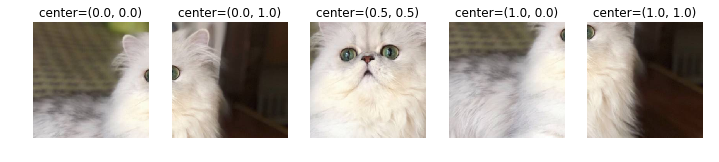

In [34]:
fig, axs = plt.subplots(1,5,figsize=(12,4))
for center, ax in zip([[0.,0.], [0.,1.],[0.5,0.5],[1.,0.], [1.,1.]], axs):
    crop(get_ex(), 300, *center).show(ax=ax, title=f'center=({center[0]}, {center[1]})')

**crop_pad**

`crop_pad(x, size, padding_mode='reflection', row_pct:uniform=0.5, col_pct:uniform=0.5) → Image :: TfmCrop`
        
* x：要转换的图像
* size：裁剪的大小，如果是int，则裁剪为正方形
* padding_mode：如何填充输出图像（'零'，'边框'或'反射'）
* row_pct：介于0和1之间，中心在y轴上的位置（0为顶部，1为底部，0.5为中心）
* col_pct：在0和1之间，中心在x轴上的位置（0为左，1为右，0.5为中心） 

这类似于裁剪，但如果目标尺寸大于图像的尺寸（在任一维度上），则根据padding_mode应用填充（请参阅垫以获取所有选项的示例）并在该维度上忽略中心的位置。

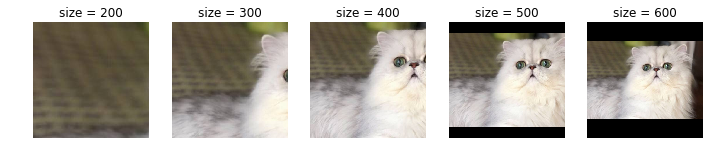

In [35]:
fig, axs = plt.subplots(1,5,figsize=(12,4))
for size, ax in zip(np.linspace(200,600,5), axs):
    crop_pad(get_ex(), int(size), 'zeros', 0.,0.).show(ax=ax, title=f'size = {int(size)}')

**dihedral**

`dihedral(x, k:partial(uniform_int, 0, 7)) → Image :: TfmPixel`
        
基于k随机翻转x图像。

该变换适用于翻转（水平或垂直）和90度的倍数的旋转。

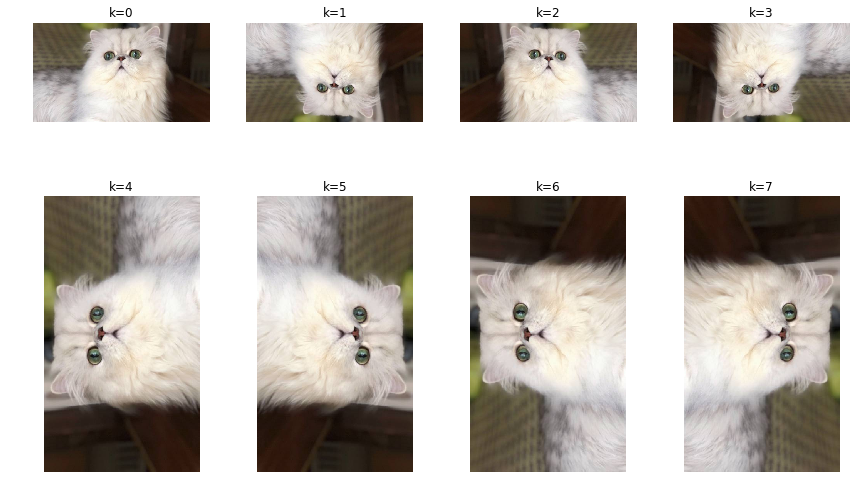

In [37]:
fig, axs = plt.subplots(2,4,figsize=(12,8))
for k, ax in enumerate(axs.flatten()):
    dihedral(get_ex(), k).show(ax=ax, title=f'k={k}')
plt.tight_layout()

**dihedral_affine**

`dihedral_affine(k:partial(uniform_int, 0, 7)) → Image :: TfmAffine`

基于k随机翻转x图像。

这是二面体的仿射实现，如果目标是ImagePoints或ImageBBox，则应该使用该实现。

**flip_lr**

`flip_lr(x) → Image :: TfmPixel`

水平翻转x。

此变换水平翻转图像。 flip_lr镜像图像。

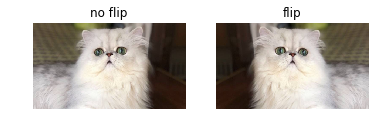

In [38]:
fig, axs = plt.subplots(1,2,figsize=(6,4))
get_ex().show(ax=axs[0], title=f'no flip')
flip_lr(get_ex()).show(ax=axs[1], title=f'flip')

**flip_affine**

`flip_affine() → Image :: TfmAffine`

水平翻转x。

这是flip_lr的仿射实现，如果目标是ImagePoints或ImageBBox，则应该使用它。

**jitter**

`jitter(c, magnitude:uniform) → Image :: TfmCoord`

该变换通过用邻近的像素替换它们来改变图像的像素（邻域延伸的距离由幅度值控制）。

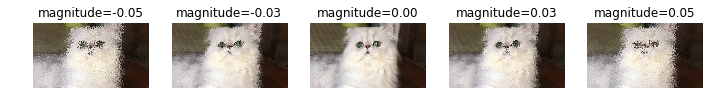

In [39]:
fig, axs = plt.subplots(1,5,figsize=(12,4))
for magnitude, ax in zip(np.linspace(-0.05,0.05,5), axs):
    tfm = jitter(magnitude=magnitude)
    get_ex().jitter(magnitude).show(ax=ax, title=f'magnitude={magnitude:.2f}')


**pad**

`pad(x, padding:int, mode='reflection') → Image :: TfmPixel`

根据模式通过在图片的每一侧添加填充像素来填充图像：

* mode ='zeros'：用零填充，
* mode ='border'：重复边框处的像素。
* mode ='reflection'：通过将像素对称到边框来填充。

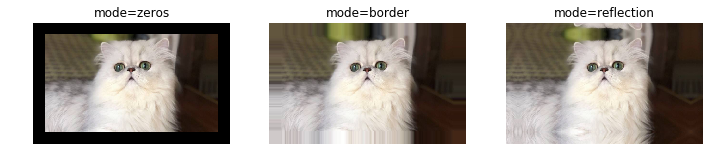

In [40]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
for mode, ax in zip(['zeros', 'border', 'reflection'], axs):
    pad(get_ex(), 50, mode).show(ax=ax, title=f'mode={mode}')

**perspective_warp**

`perspective_warp(c, magnitude:partial(uniform, size=8)=0, invert=False) → Image :: TfmCoord`

对c应用歪曲。

透视变形是在3D平面的不同平面中看到的图像变形。 通过告诉我们想要图像的四个角中的每一个来确定新平面（从-1到1，-1是左/上，1是右/下）。

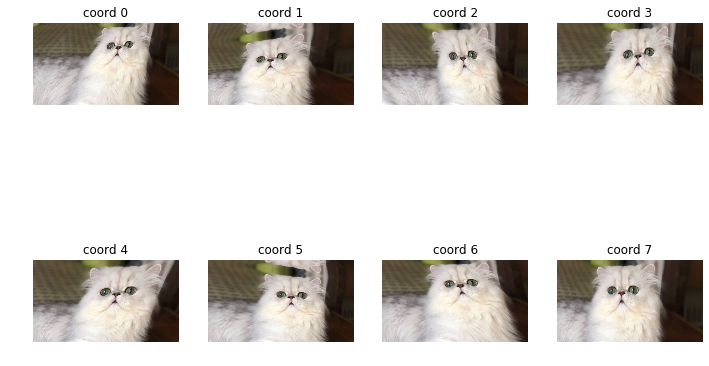

In [41]:
fig, axs = plt.subplots(2,4,figsize=(12,8))
for i, ax in enumerate(axs.flatten()):
    magnitudes = torch.tensor(np.zeros(8))
    magnitudes[i] = 0.5
    perspective_warp(get_ex(), magnitudes).show(ax=ax, title=f'coord {i}')

## resize

Pytorch的transforms.Resize（size）等价是在fastai中没有显式转换函数的情况下实现的。 它是通过参数size和resize_method完成的。

size参数可以是单个int 224，也可以是int的元组（224,400）。 默认行为是在传递单个int时将图像裁剪为正方形，并在元组的情况下将其压缩，以便：

* if size=224 is passed, 它会调整大小然后裁剪到 (224,224)
* if size=(224,400) is passed, 它会被压缩 (224,400)
* if size=(224,224) is passed, 它会被压缩（而不是剪裁！） (224,224)

您可以覆盖默认的resize_method。

注意：

如果您收到类似于下面的错误：

```
RuntimeError: Argument #4: Padding size should be less than the corresponding input dimension, but got: padding (46, 46) at dimension 3 of input [1, 3, 128, 36]
```

这是由PyTorch的反射填充问题引起的，默认情况下库使用它。 添加额外的关键字参数padding_mode ='zeros'应该可以作为现在的解决方法。

调整大小的方式略有不同，具体取决于ImageDataBunch的创建方式：

1. 使用快捷方式ImageDataBunch from_ *方法时，size和resize_method参数将与其余参数一起传递。 例如，要使用from_name_re方法动态调整图像大小到224x224，请执行以下操作：
```
data = ImageDataBunch.from_name_re(path_img, fnames, pat, size=224, bs=bs)
```
并覆盖resize_method：

```
data = ImageDataBunch.from_name_re(path_img, fnames, pat, size=224, resize_method=ResizeMethod.SQUISH, bs=bs)
```

2. 使用数据块API时，size和resize_method通过transform方法传递。 例如：

```
src = ImageList.from_folder(path).split_none().label_from_folder()
tfms = get_transforms() # or tfms=None if none are needed
size=224 # size=(224,224) or (400,224)
data = src.transform(tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH).databunch(bs=bs, num_workers=4).normalize()
```

**在训练前调整大小**

请注意，如果您只想调整输入图像的大小，通过转换动态执行操作效率很低，因为必须在重新运行的每个笔记本上完成。 您可能希望调整文件系统上的图像大小，并根据需要使用调整大小的数据集。

例如，您可以使用fastai代码执行此操作，在`small-96`下创建低分辨率图像，在`small-256`下创建中分辨率图像：

```python
from fastai.vision import *

path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

il = ImageList.from_folder(path_hr)

def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=75)

# create smaller image sets the first time this nb is run
sets = [(path_lr, 96), (path_mr, 256)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)
```

当然，调整质量，重新采样和其他参数以满足您的需求。 你还需要调整自定义目录（train, test, etc）

**rotate**

`rotate(degrees:uniform) → Image :: TfmAffine`

按度旋转图像。

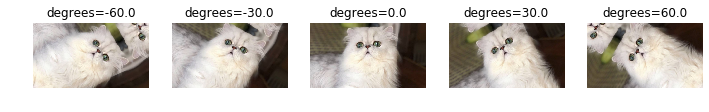

In [42]:
fig, axs = plt.subplots(1,5,figsize=(12,4))
for deg, ax in zip(np.linspace(-60,60,5), axs):
    get_ex().rotate(degrees=deg).show(ax=ax, title=f'degrees={deg}')

**rgb_randomize**

`rgb_randomize(x, channel:int=None, thresh:float=0.3) → Image :: TfmPixel`
        
随机化输入图像的一个通道

* channel：要随机化的通道（RGB）
* thresh：随机化后，将值缩放到不超过阈值

通过随机化三个通道中的一个，学习者基本上看到相同的图像，但具有不同的颜色。 通常，每个RGB图像都有一个占优势的通道，随机化该通道是最危险的; 因此，必须应用低阈值（阈值）值。 在这个例子中，绿色通道是主导通道。

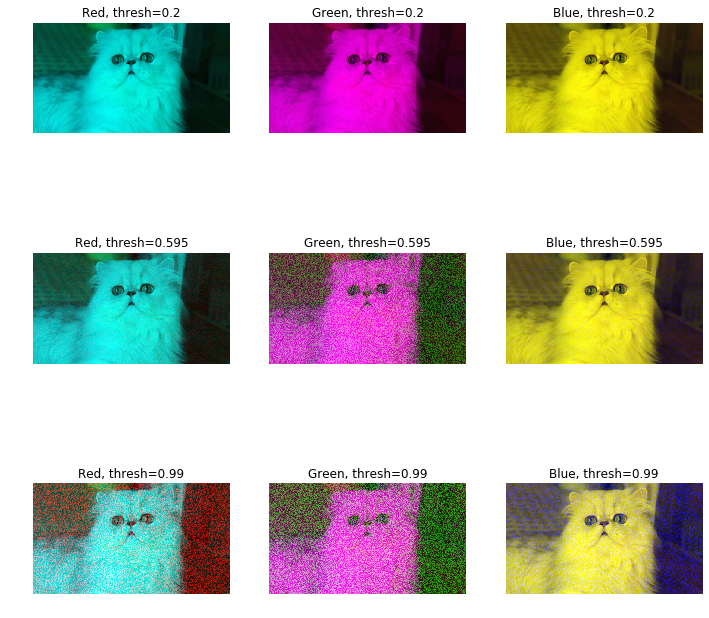

In [43]:
fig, axs = plt.subplots(3,3,figsize=(12,12))
channels = ['Red', 'Green', 'Blue']

for i in np.arange(0, 3):
    for thresh, ax in zip(np.linspace(0.2, 0.99, 3), axs[:, i]):
        get_ex().rgb_randomize(channel = i, thresh = thresh).show(
            ax=ax, title = f'{channels[i]}, thresh={thresh}')

**skew**

`skew(c, direction:uniform_int, magnitude:uniform=0, invert=False) → Image :: TfmCoord`

具有随机`direction`（方向）和`magnitude`（幅度）的倾斜`c`字段。

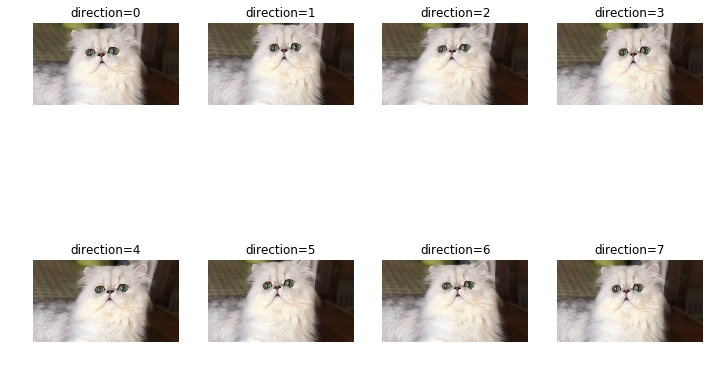

In [44]:
fig, axs = plt.subplots(2,4,figsize=(12,8))
for i, ax in enumerate(axs.flatten()):
    get_ex().skew(i, 0.2).show(ax=ax, title=f'direction={i}')

**squish**

`squish(scale:uniform=1.0, row_pct:uniform=0.5, col_pct:uniform=0.5) → Image :: TfmAffine`
        
按比例缩小图像。 row_pct，col_pct选择缩放焦点。   

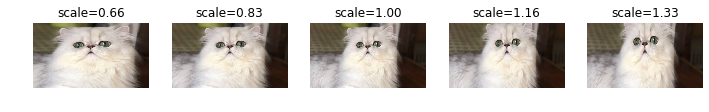

In [45]:
fig, axs = plt.subplots(1,5,figsize=(12,4))
for scale, ax in zip(np.linspace(0.66,1.33,5), axs):
    get_ex().squish(scale=scale).show(ax=ax, title=f'scale={scale:.2f}')

**symmetric_warp**

`symmetric_warp(c, magnitude:partial(uniform, size=4)=0, invert=False) → Image :: TfmCoord`

对c应用对称扭曲。

同时应用四个倾斜，每个倾斜具有矢量幅度给定的强度。 请参阅下方的倾斜，了解每个倾斜的效果。

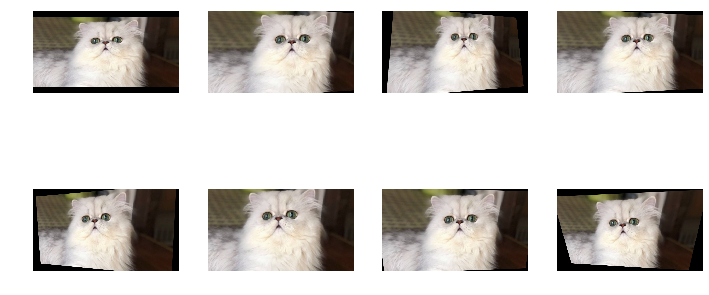

In [46]:
tfm = symmetric_warp(magnitude=(-0.2,0.2))
_, axs = plt.subplots(2,4,figsize=(12,6))
for ax in axs.flatten():
    img = get_ex().apply_tfms(tfm, padding_mode='zeros')
    img.show(ax=ax)

**tilt**

`tilt(c, direction:uniform_int, magnitude:uniform=0, invert=False) → Image :: TfmCoord`
        
随机方向和幅度倾斜c场。

direction是一个数字（0：左，1：右，2：顶部，3：底部）。 正幅度是向前倾斜（朝向观看图像的人），向负倾斜向后倾斜。

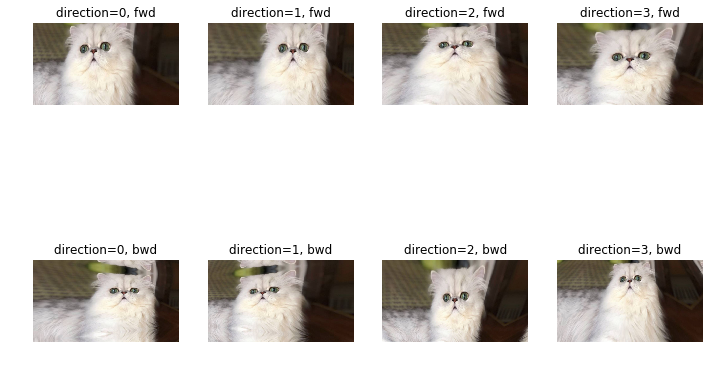

In [48]:
fig, axs = plt.subplots(2,4,figsize=(12,8))
for i in range(4):
    get_ex().tilt(i, 0.4).show(ax=axs[0,i], title=f'direction={i}, fwd')
    get_ex().tilt(i, -0.4).show(ax=axs[1,i], title=f'direction={i}, bwd')

**zoom**

`zoom(scale:uniform=1.0, row_pct:uniform=0.5, col_pct:uniform=0.5) → Image :: TfmAffine`
        
按比例缩放图像。 row_pct，col_pct选择缩放焦点。    

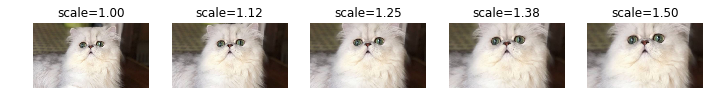

In [50]:
fig, axs = plt.subplots(1,5,figsize=(12,4))
for scale, ax in zip(np.linspace(1., 1.5,5), axs):
    get_ex().zoom(scale=scale).show(ax=ax, title=f'scale={scale:.2f}')


**cutout**

`cutout(x, n_holes:uniform_int=1, length:uniform_int=40) → Image :: TfmPixel`
        
在随机位置的图像中切出n_holes个大小长度的方孔。

本文描述的归一化技术：具有剪切的卷积神经网络的改进正则化

默认情况下，它将应用单个剪切（n_holes = 1）长度= 40），概率p = 1。 切口位置始终是随机的。 如果您选择执行多个剪切，它们可能会重叠。

上面的论文使用CIFAR-10（10类分类）的尺寸为16x16的切口和CIFAR-100（100类）的尺寸为8x8的切口。 通常，类别越多，您想要的剪切越少。

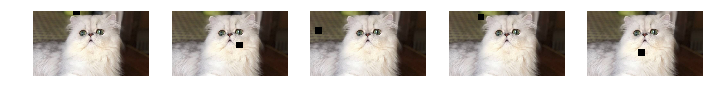

In [52]:
tfms = [cutout()]
fig, axs = plt.subplots(1,5,figsize=(12,4))
for ax in axs:
    get_ex().apply_tfms(tfms).show(ax=ax)

您可以在剪切块中添加一些随机性，如下所示：

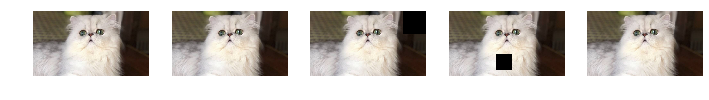

In [53]:
tfms = [cutout(n_holes=(1,4), length=(10, 160), p=.5)]
fig, axs = plt.subplots(1,5,figsize=(12,4))
for ax in axs:
    get_ex().apply_tfms(tfms).show(ax=ax)

---

## 便利功能
这些函数简化了crop_pad和zoom的随机版本的创建。

**rand_crop**

`rand_crop(*args, padding_mode='reflection', p:float=1.0)`

随机版本的crop_pad。

args用于内部目的，不应触及。

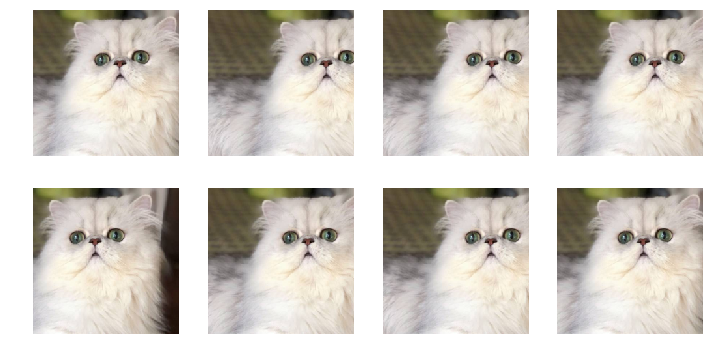

In [54]:
tfm = rand_crop()
_, axs = plt.subplots(2,4,figsize=(12,6))
for ax in axs.flatten():
    img = get_ex().apply_tfms(tfm, size=224)
    img.show(ax=ax)

**rand_pad**

`rand_pad(padding:int, size:int, mode:str='reflection')`

固定模式填充和随机裁剪的大小

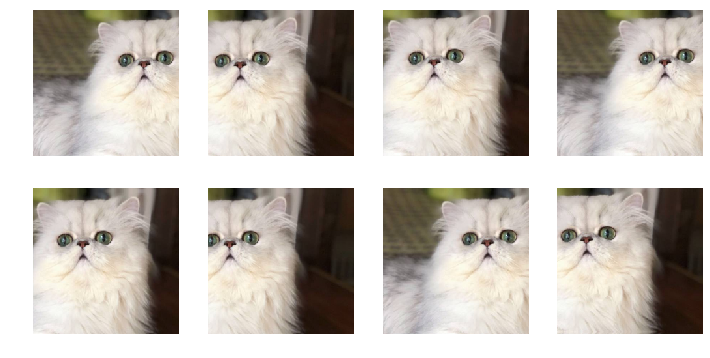

In [55]:
tfm = rand_pad(4, 224)
_, axs = plt.subplots(2,4,figsize=(12,6))
for ax in axs.flatten():
    img = get_ex().apply_tfms(tfm, size=224)
    img.show(ax=ax)

**rand_zoom**

`rand_zoom(scale:uniform=1.0, p:float=1.0)`

随机版缩放。

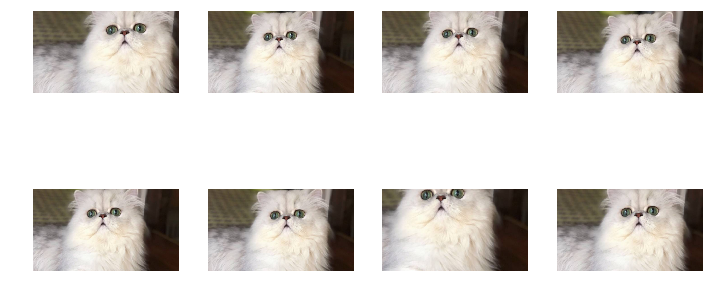

In [56]:
tfm = rand_zoom(scale=(1.,1.5))
_, axs = plt.subplots(2,4,figsize=(12,6))
for ax in axs.flatten():
    img = get_ex().apply_tfms(tfm)
    img.show(ax=ax)